### 1. Import netNMFsc and initialize an operator using either netNMFGD or netNMFMU

In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 
%load_ext autotime
import netNMFsc
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time as t
dimensions = 5
n_inits = 1
max_iters = 1000000
tol = 1e-2
n_jobs = 1
# Gradient descent operator (generally performs significantly faster than multiplicative update)
operator = netNMFsc.netNMFGD(d=dimensions, n_inits=n_inits, max_iter=max_iters, n_jobs=n_jobs,distance='frobenius')
# alternatively can use multiplicative update operator:
# operator = netNMFMU(d=dimensions, alpha=alpha, n_inits=n_inits, tol=tol, max_iter=max_iters, n_jobs=n_jobs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.49 ms (started: 2021-02-16 10:59:40 -05:00)


### 1. Import gene expression matrix and gene names

If expression data is from 10X genomics and is contained in a folder containing matrix.mtx,barcodes.tsv, and genes.tsv or a hdf5 file, data can be loaded automatically using:

In [97]:
# if data is in .hdf5 format genome indicates the reference genome (typically 'mm10' or 'hg19')
genome=None
# if data is in .hdf5 format then teXdir is the .hdf5 file. If not then it is 
# the folder containing matrix.mtx and genes.tsv
tenXdir=None
operator.load_10X(direc=tenXdir,genome=genome)

AttributeError: 'NoneType' object has no attribute 'endswith'

time: 10.9 ms (started: 2021-02-07 14:58:58 -05:00)


In [3]:
data_f = '../generate_data/resampled_netnmfsc.mat'

time: 685 µs (started: 2021-02-16 10:55:26 -05:00)


In [23]:
X = scipy.io.loadmat(data_f)
X = list(list(X['X1'])[0])
net_path = "/home/jay/ExtraDrive1/External/experiments/r2rilsexperiment/netnmfsc/netNMF-sc/"
genes = np.load(net_path+'netNMFsc/data/test_genes.npy')
operator.genes = genes
network_file_name = net_path+'netNMFsc/data/test_network.npy'
netgenes_file_name = net_path+'netNMFsc/data/test_netgenes.npy'
operator.load_network(net=network_file_name,genenames=netgenes_file_name)
print('network shape is:',operator.N.shape, 'and number of genes is:',len(operator.netgenes))
print(operator.netgenes[0:10],'gene names are in gene entrez id format')

2700 edges in network
network shape is: (100, 100) and number of genes is: 100
['22847' '83937' '9855' '51778' '541565' '2979' '90737' '103' '79611'
 '26277'] gene names are in gene entrez id format
time: 2.62 s (started: 2021-02-16 10:58:26 -05:00)


In [90]:
inits= scipy.io.loadmat('/home/jay/ExtraDrive1/External/experiments/r2rilsexperiment/laplacian_regularization/boxR2RNNGLS/test/comparisons/runtime/smooth_initialization_objectives_large.mat')

time: 1.39 ms (started: 2021-02-18 16:12:30 -05:00)


In [91]:
inits

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Feb 18 16:12:24 2021',
 '__version__': '1.0',
 '__globals__': [],
 'H0': array([[0.        , 0.23009844, 1.17299965, 2.20890349, 0.15794735],
        [1.44833584, 2.09817085, 0.08201008, 0.        , 0.        ],
        [0.61016618, 0.        , 0.53988085, 0.09648339, 2.8212544 ],
        ...,
        [1.3406529 , 0.        , 1.61982227, 0.        , 0.66368728],
        [0.45257304, 1.40530303, 0.        , 0.        , 2.29834023],
        [0.12086626, 0.34222769, 1.06376259, 1.79368821, 0.        ]]),
 'W0': array([[0.4742658 , 0.23644491, 0.09520452, 0.20118595, 0.11624056],
        [0.51119831, 0.35940922, 0.23072655, 0.65503551, 0.22196988],
        [0.52529217, 0.35722416, 0.20764817, 0.30235174, 0.46992086],
        [0.        , 0.248883  , 0.18223788, 0.40747085, 0.30470034],
        [0.29768717, 0.28187441, 0.05394283, 0.57212969, 0.16575823],
        [0.25409709, 0.23091271, 0.23885098, 0.27144428, 0.17984

time: 6.58 ms (started: 2021-02-18 16:12:31 -05:00)


In [92]:
H0 = inits['H0']
W0 = inits['W0']

time: 688 µs (started: 2021-02-18 16:12:33 -05:00)


In [94]:
ntrials = 1
times = np.zeros([len(X),ntrials])
ix = 4
for nt in range(ntrials):
    operator = netNMFsc.netNMFGD(d=dimensions, 
                                 weight=0,n_inits=n_inits,
                                 sparsity=0, max_iter=1000000,
                                 n_jobs=n_jobs,test=True,
                                 tol = 1e-10,W0=W0, H0=H0.T,distance='frobenius')
    operator.X = X[ix]
    operator.genes = genes
    start = t.time()
    operator.load_network(net=network_file_name,genenames=netgenes_file_name)
    print('number of points is:', operator.X.shape[1])
    print('network shape is:',operator.N.shape, 'and number of genes is:',len(operator.netgenes))

    W,H,T,objs = operator.fit_transform()
    end = t.time()
    times[ix,nt] = end-start

2700 edges in network
number of points is: 1440
network shape is: (100, 100) and number of genes is: 100
querying 1-100...done.
Finished.
2641 edges in network
library size normalizing...
2641 edges
1.0 0.0 26316.0
Starting objective:[6815.62207031]
Starting fro:5315.622
Starting LQF:1500.0
0 6812.2217 inf
30000 4282.6045 4.3901367
60000 3997.2412 1.932373
90000 3850.901 1.1123047
120000 3762.4346 0.70751953
150000 3703.1357 0.5
180000 3660.3901 0.36669922
210000 3628.163 0.2854004
240000 3602.5786 0.23120117
270000 3581.3481 0.1940918
300000 3563.4255 0.16552734
330000 3547.9802 0.14453125
360000 3534.372 0.12866211
390000 3522.237 0.115478516
420000 3511.331 0.104003906
450000 3501.4963 0.09301758
480000 3492.7317 0.08325195
510000 3484.7502 0.076660156
540000 3477.4412 0.06933594
570000 3470.7744 0.064453125
600000 3464.617 0.05908203
630000 3458.8955 0.05493164
660000 3453.5735 0.05126953
690000 3448.634 0.04736328
720000 3444.0637 0.043945312
750000 3439.803 0.041015625
780000 343

In [95]:
scipy.io.savemat('comparisons/runtime/python_runtimes_obj.mat',{'pytimes':T,'py_obj':objs})

time: 2.23 s (started: 2021-02-18 18:27:53 -05:00)


If not, data can be loaded into a numpy array using your favorite method based on the file format of your data. For example, if your data is saved as numpy arrays:

In [40]:
scipy.io.savemat('python_times',{'pytimes':times})

time: 1.23 ms (started: 2021-02-16 12:34:55 -05:00)


In [5]:
export = dict(x=X, y=genes)


time: 785 µs (started: 2021-02-01 12:41:58 -05:00)


This dataset contains 3 clusters of cells and over 90% of the values in the data are dropped out (zero)

### 3. Run netNMFsc

In [41]:
times

array([[ 36.63730955,  39.83954549,  39.49892282,  41.19645476,
         38.65527701],
       [ 41.68475437,  44.67058134,  47.05867076,  45.27945542,
         46.5540843 ],
       [ 52.75361967,  53.81867003,  53.8071804 ,  54.15357375,
         53.98605227],
       [ 68.99698567,  69.19058371,  69.98774552,  69.97065735,
         72.01587892],
       [ 93.28419065,  92.54966497,  94.37296271, 100.29866314,
         98.98863578]])

time: 2.11 ms (started: 2021-02-16 12:51:10 -05:00)


In [42]:
t.time()

1613497889.926484

time: 1.82 ms (started: 2021-02-16 12:51:29 -05:00)


### 4. Downstream analysis

In [93]:
from netNMFsc import plot

from sklearn.decomposition import PCA
pca = PCA(n_components=dimensions)
pca.fit(X)
components = pca.components_
k,clusters = plot.select_clusters(components)
plot.tSNE(components,clusters)
plt.title('Before netNMF-sc, incorrect clustering :(')
plt.show()

# Select number of cluster from d-dimensional cell matrix, H and plot tSNE projection
k,clusters = plot.select_clusters(H)
plot.tSNE(H,clusters)
plt.title('After netNMF-sc, correct clustering! :)')
plt.show()


7 clusters with average silhouette score: 0.27001654166968475


ValueError: too many values to unpack (expected 2)

time: 809 ms (started: 2021-02-07 11:14:45 -05:00)


### Script for running netNMF-sc from the command line

# Load R2Rmatlab comparison

In [69]:
matlab = scipy.io.loadmat('/home/jay/ExtraDrive1/External/experiments/r2rilsexperiment/laplacian_regularization/R2Rembedding.mat')

time: 1.42 ms (started: 2021-02-02 12:44:48 -05:00)


In [70]:
r2r_embedding = matlab['Xnu']

time: 699 µs (started: 2021-02-02 12:44:49 -05:00)


7 clusters with average silhouette score: 0.27001654166968475
2 clusters with average silhouette score: 0.4868879
3 clusters with average silhouette score: 0.47229112812485846


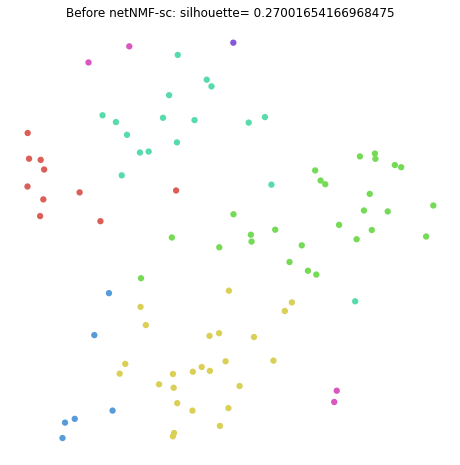

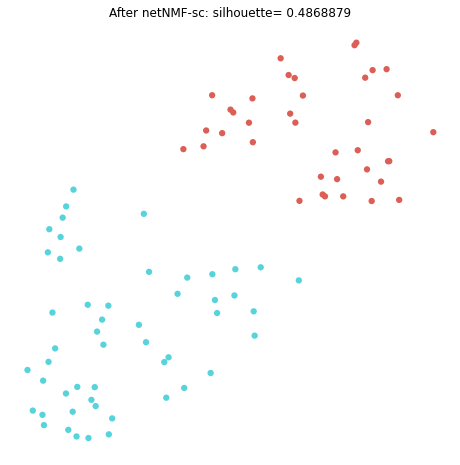

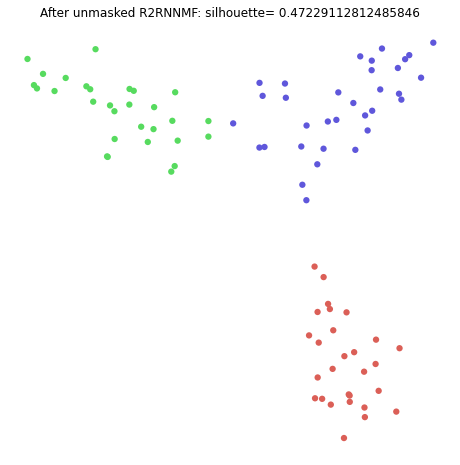

time: 4.52 s (started: 2021-02-07 15:01:14 -05:00)


In [102]:
from netNMFsc import plot

from sklearn.decomposition import PCA
pca = PCA(n_components=dimensions)
pca.fit(X)
components = pca.components_
k,clusters,score = plot.select_clusters(components)
plot.tSNE(components,clusters)
plt.title('Before netNMF-sc: silhouette= '+str(score))
plt.savefig('python_comp_Xpca.jpeg')


# Select number of cluster from d-dimensional cell matrix, H and plot tSNE projection
# k,clusters = plot.select_clusters(H)
# plot.tSNE(H,clusters)
# plt.title('After netNMF-sc, correct clustering! :)')
# plt.show()
k,clusters,score = plot.select_clusters(H)
plot.tSNE(H,clusters)
plt.title('After netNMF-sc: silhouette= '+str(score))
plt.savefig('python_comp_Xnetnmfsc.jpeg')

k,clusters,score = plot.select_clusters(r2r_embedding.T)
plot.tSNE(r2r_embedding.T,clusters,)
plt.title('After unmasked R2RNNMF: silhouette= '+str(score))
plt.savefig('python_comp_XR2R.jpeg')

3 clusters with average silhouette score: 0.39337158


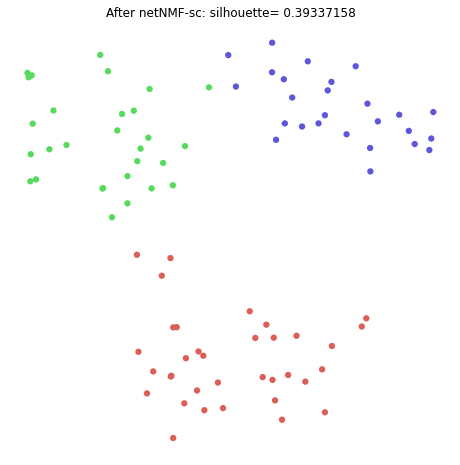

time: 1.52 s (started: 2021-02-07 11:15:03 -05:00)


In [94]:
k,clusters,score = plot.select_clusters(H)
plot.tSNE(H,clusters)
plt.title('After netNMF-sc: silhouette= '+str(score))
plt.savefig('python_comp_Xnetnmfsc.jpeg')

In [95]:
results_export = {'Wpy':W,'Hpy':H,'clusters':clusters}
results_export['A'] = operator.N
results_export['netgenes'] = operator.netgenes
results_export['X'] = X
results_export['Y'] = genes

matlab = scipy.io.savemat('/home/jay/ExtraDrive1/External/experiments/r2rilsexperiment/laplacian_regularization/netnmf_results.mat',results_export)

time: 1.96 ms (started: 2021-02-07 11:15:07 -05:00)
